# Next Word Prediction
By
Afnan Hussain & Alaiba Nawaz

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import datetime
import nltk
import string
import os
import re
from nltk.corpus import stopwords
from tensorflow.keras.models import load_model, save_model
from nltk.util import bigrams
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import spacy
import tensorflow as tf
import pickle
from openpyxl.workbook import Workbook
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import LearningRateScheduler
from keras.layers import Dropout
from keras.optimizers import Adam
nlp = spacy.load("en_core_web_sm")

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#Libraries for visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
import csv

filtered_sentences = []

with open('PreprocssedData - Sheet1.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        filtered_sentences.append(row)

In [ ]:
len(filtered_sentences)

22666

In [ ]:
col_name = ["Sentences"]
df_filtered = pd.DataFrame(filtered_sentences,columns=col_name)

In [ ]:
df_filtered = df_filtered[df_filtered["Sentences"]!="Sentences"]
df_filtered

,Sentences
1,montessori own handbook produced by alicia wil...
2,illustration maria montessori dr
3,montessori own handbook by maria montessori au...
4,with new york frederick stokes company publishers
5,copyright frederick stokes company
...,...
22661,dieusy surveyed them for a moment with blank a...
22662,then with swift intelligence grasped the fact ...
22663,he sprang upon them tore them asunder fell hea...
22664,guerchard dashed to the door tried it and foun...


In [ ]:
sentences = df_filtered['Sentences'].tolist()
words = [word_tokenize(sentence) for sentence in sentences]
words_without_stopwords = []
stop_words = set(stopwords.words('english'))
for line in words:
  for word in line:
    if word not in stop_words:
      words_without_stopwords.append(word)

In [ ]:
words_freq = Counter(words_without_stopwords)

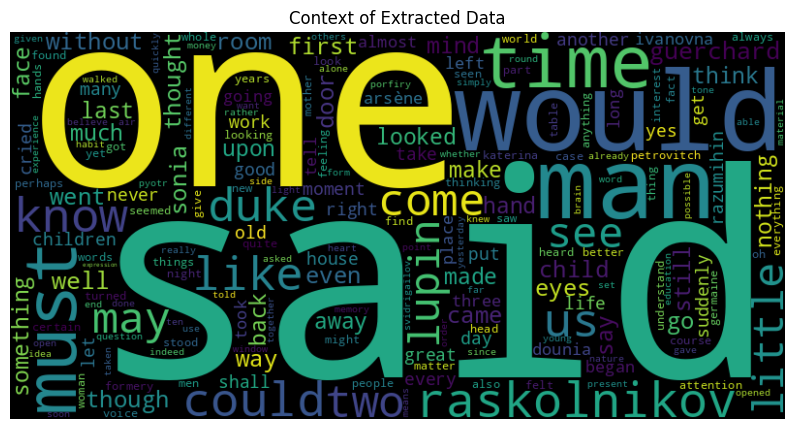

In [ ]:
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(words_freq)

plt.figure(figsize=(10, 8))
plt.title("Context of Extracted Data")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
word_lengths = df_filtered['Sentences'].apply(lambda x: len(x.split()))

fig = px.histogram(x=word_lengths, nbins=25, title='Distribution of Word Lengths in Filtered Sentences')
fig.update_layout(xaxis_title='Word Length', yaxis_title='Frequency')
fig.update_traces(marker=dict(line=dict(color='black', width=1)))
fig.show()

In [ ]:
sentences = df_filtered['Sentences'].tolist()
# Function to count stopwords and other words
def count_words(sentence):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(sentence)
    num_stopwords = len([word for word in words if word.lower() in stop_words])
    num_other_words = len(words) - num_stopwords
    return num_stopwords, num_other_words

# Count stopwords and other words for each sentence
total_stopwords, total_other_words = zip(*[count_words(sentence) for sentence in sentences])

# Create a grouped bar chart
fig = px.bar(x=['Stopwords', 'Other Words'], y=[sum(total_stopwords), sum(total_other_words)],
             title='Total Number of Stopwords and Other Words in All Sentences',
             labels={'value': 'Word Count', 'variable': 'Word Type'},
             color=['Stopwords', 'Other Words'])
fig.update_layout(barmode='group')

fig.show()

In [ ]:
sentences_tokenized = [word_tokenize(str(sentence).strip()) for sentence in df_filtered['Sentences']]
sentences_bigrams = [list(bigrams(tokens)) for tokens in sentences_tokenized]


structured_bigrams = []


for i, sentence_bigrams in enumerate(sentences_bigrams, start=1):
    for bigram in sentence_bigrams:
        structured_bigrams.append({
            'Sentence': f"Sentence {i}",
            'Bigram': ' '.join(bigram)
        })

df_bigrams = pd.DataFrame(structured_bigrams)

bigram_counts = df_bigrams['Bigram'].value_counts().reset_index()
bigram_counts.columns = ['Bigram', 'Frequency']


df_bigrams = df_bigrams.merge(bigram_counts, on='Bigram')

# Calculate bigram probabilities
df_bigrams['Probability'] = df_bigrams.groupby('Sentence')['Frequency'].transform(lambda x: x / x.sum())


In [ ]:
df_bigrams

,Sentence,Bigram,Frequency,Probability
0,Sentence 1,he could,108,0.156522
1,Sentence 2,he could,108,0.070913
2,Sentence 22,he could,108,0.076003
3,Sentence 31,he could,108,0.124567
4,Sentence 35,he could,108,0.187826
...,...,...,...,...
126732,Sentence 8001,had rented,1,0.001172
126733,Sentence 8001,rented a,1,0.001172
126734,Sentence 8001,box at,1,0.001172
126735,Sentence 8001,lyonnais in,1,0.001172


In [ ]:
vectorizer = TfidfVectorizer()
filtered_sentences_TFIDF = vectorizer.fit_transform(df_filtered['Sentences'].tolist())

In [ ]:
filtered_sentences_TFIDF

<8001x8439 sparse matrix of type '<class 'numpy.float64'>'
	with 114406 stored elements in Compressed Sparse Row format>

In [ ]:
# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(filtered_sentences_TFIDF.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df

,aback,abandon,abandoned,abandoning,abbey,aberration,abjure,able,abnormal,abnormality,...,zametov,zaraïsk,zarnitsyn,zeal,zest,zigzags,zossimov,æsthetically,æsthetics,êtes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split

# **LSTM Model**

In [ ]:
sentences = df_filtered['Sentences'].tolist()
print("No. of sentences:",len(sentences))
# Tokenize the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

total_words = len(tokenizer.word_index) + 1

# Create input sequences and labels
input_sequences = []
for sentence in sentences:
    tokenized_sentence = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(tokenized_sentence)):
        n_gram_sequence = tokenized_sentence[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

X, y = input_sequences[:, :-1], input_sequences[:, -1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


No. of sentences: 22665


In [ ]:
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Build the RNN model
with tf.device(device_name):
  model_filtered = Sequential()
  model_filtered.add(Embedding(total_words, 50, input_length=max_sequence_length-1))
  model_filtered.add(LSTM(units=100, return_sequences=True))
  model_filtered.add(LSTM(100))
  model_filtered.add(Dropout(0.2))
  model_filtered.add(Dense(total_words, activation='softmax'))

  adam_optimizer = Adam(clipvalue=0.5)
  model_filtered.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

def lr_scheduler(epoch, lr):
      return lr * 0.9  # You can adjust the multiplier as needed.

model_filtered.fit(X_train, y_train, epochs=10,batch_size=100, callbacks=[LearningRateScheduler(lr_scheduler)], verbose=1)

Epoch 1/10
3124/3124 [==============================] - 292s 91ms/step - loss: 6.5678 - accuracy: 0.0733 - lr: 9.0000e-04
Epoch 2/10
3124/3124 [==============================] - 241s 77ms/step - loss: 6.0722 - accuracy: 0.1037 - lr: 8.1000e-04
Epoch 3/10
3124/3124 [==============================] - 236s 76ms/step - loss: 5.7822 - accuracy: 0.1242 - lr: 7.2900e-04
Epoch 4/10
3124/3124 [==============================] - 234s 75ms/step - loss: 5.5924 - accuracy: 0.1347 - lr: 6.5610e-04
Epoch 5/10
3124/3124 [==============================] - 234s 75ms/step - loss: 5.4490 - accuracy: 0.1416 - lr: 5.9049e-04
Epoch 6/10
3124/3124 [==============================] - 234s 75ms/step - loss: 5.3425 - accuracy: 0.1461 - lr: 5.3144e-04
Epoch 7/10
3124/3124 [==============================] - 235s 75ms/step - loss: 5.2552 - accuracy: 0.1508 - lr: 4.7830e-04
Epoch 8/10
3124/3124 [==============================] - 234s 75ms/step - loss: 5.1836 - accuracy: 0.1530 - lr: 4.3047e-04
Epoch 9/10
3124/3124 [==

In [ ]:
model_filtered.save('filtered_DL_model.keras')

In [ ]:
loaded_filtered_model = load_model('filtered_DL_model.keras')

In [ ]:
max_sequence_length

724

In [ ]:
model_filtered.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
def visualize_next_word(input_words):
    input_sequence = tokenizer.texts_to_sequences([input_words])[0]
    input_sequence = pad_sequences([input_sequence], maxlen=max_sequence_length-1, padding='pre')
    predicted_probabilities = loaded_filtered_model.predict(input_sequence, verbose=0).flatten()


    top_n = 5
    top_indices = predicted_probabilities.argsort()[-top_n:][::-1]
    top_words = [tokenizer.index_word.get(idx, "<Unknown>") for idx in top_indices]
    top_probabilities = predicted_probabilities[top_indices]

    fig = go.Figure(data=[go.Bar(x=top_words, y=top_probabilities)])
    fig.update_layout(title=f'Next Word Prediction for "{input_words}"',
                      xaxis_title='Next Word',
                      yaxis_title='Probability',
                      hovermode='x',
                      hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial"))

    fig.show()

In [ ]:
while True:
    input_words = input("Enter words (or press Enter to stop): ").lower()
    if not input_words:
        break
    visualize_next_word(input_words)

Enter words (or press Enter to stop): 
